In [1]:
import pandas as pd

In [5]:
df_hvg = pd.read_csv('/Users/pacohoche/Desktop/AI-1 Project/AI-1-Project-Single-Cell-/Data_CSV/hvg_data_clusters.csv', index_col=0)
df_hvg.head()

,Coro2b,Clec9a,Tmem167b,Rag2,Adgre1,Bhlhb9,Vcam1,Mns1,Tbc1d5,Sardh,...,Mzb1,Cables1,B4galt6,Impact,Taf4b,Zfp521,Hrh4,Psma8,cluster,cell_type
f8f4122d32,-0.459152,-0.146910,2.137775,3.327965,-0.265706,1.437795,0.405014,-0.679011,-0.703729,-0.133520,...,-0.391854,-0.502104,-0.159891,-0.926282,-1.002289,0.181816,-0.101194,2.288715,2.0,LMPP_broad
c547632b57,-0.459152,-0.146910,2.564433,-0.010832,-0.265706,-0.781545,-0.604030,-0.591253,1.743835,-0.133520,...,-0.391854,-0.502104,0.023667,1.117386,-0.528065,0.186905,-0.101194,-0.054558,NaN,NaN
c2e46e7dfc,-0.459152,-0.146910,-0.767338,-0.079042,-0.265706,-0.642470,-0.604030,0.143596,1.319571,-0.133520,...,-0.391854,-0.502104,2.392045,0.808135,-0.160130,1.572204,-0.101194,-0.599173,NaN,NaN
0710f78e38,-0.459152,-0.146910,-0.507284,-0.621492,-0.265706,-0.641621,-0.604030,1.864635,-1.285377,-0.133520,...,0.155889,1.469079,-0.875999,1.166535,-0.486395,-0.582101,-0.101194,-0.241778,3.0,LTHSC_broad
449e822f38,1.096180,3.078086,-0.767338,-0.621492,1.874920,-0.143184,1.136466,-0.525681,0.963805,2.856626,...,0.545174,-0.502104,-0.355352,1.401348,-0.469913,-0.582101,-0.101194,-0.599173,4.0,MEP_broad


In [6]:
# divide the data into the ones with labels and the ones without labels
df_hvg_labeled = df_hvg[df_hvg['cluster'].notna()]
df_hvg_unlabeled = df_hvg[df_hvg['cluster'].isna()]



# MODELS 

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# 1) Separate features and labels
X = df_hvg_labeled.drop(columns=['cluster', 'cell_type'])
y = df_hvg_labeled['cluster']

# 2) Train/test split WITH stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y          # <--- important with imbalance
)

# 3) Create the model WITH class weights
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced'   # <--- key line
)

# 4) Train
rf.fit(X_train, y_train)

# 5) Predict
y_pred = rf.predict(X_test)

# 6) Evaluate
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=sorted(y.unique()),
    yticklabels=sorted(y.unique())
)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()
print(classification_report(y_test, y_pred, digits=3))

#### This is a very very good finding, RF Performs very very poorly on thousands of genes ! 

## Logistic reg with CV (regularized Log Reg)

In [ ]:
X = df_hvg_labeled.drop(columns=['cluster', 'cell_type']).values
y = df_hvg_labeled['cluster'].astype(int)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        class_weight="balanced",
        max_iter=5000,
        n_jobs=-1))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    pipe, X, y, cv=cv,
    scoring=["accuracy", "f1_macro"],
    n_jobs=-1
)

print(scores["test_accuracy"].mean())
print(scores["test_f1_macro"].mean())

# pipe.fit(X, y)
# predicted_clusters = pipe.predict(X_unlabeled)
# df_hvg_unlabeled['predicted_cluster'] = predicted_clusters
# df_hvg_unlabeled.head()
# finally, we can save the predicted clusters to a csv file
# df_hvg_unlabeled.to_csv('/Users/pacohoche/Desktop/AI-1 Project/AI-1-Project-Single-Cell-/Data_CSV/hvg_unlabeled_predicted_clusters.csv')



## Holy Moly XGBoost

In [19]:
# drop class 9 from the labeled dataset
df_hvg_labeled = df_hvg_labeled[df_hvg_labeled['cluster'] != 9]
# count how many cells are in each cluster
cluster_counts = df_hvg_labeled['cell_type'].value_counts()
print(cluster_counts)

cell_type
MEP_broad      256
CMP_broad      232
LMPP_broad     176
MPP3_broad     110
GMP_broad       88
LTHSC_broad     75
STHSC_broad     73
MPP1_broad      43
MPP2_broad      15
Name: count, dtype: int64


In [ ]:
X = df_hvg_labeled.drop(columns=['cluster', 'cell_type']).values
y = df_hvg_labeled['cluster'].astype(int)


In [21]:
# split the dataset for train and test with stratification
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y          # <--- important with imbalance
)


In [22]:
import numpy as np
from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# --- Just to inspect class distribution in the training set ---
print("Before SMOTETomek:", Counter(y_train))

# Choose k_neighbors safely based on the smallest class in y_train
classes, counts = np.unique(y_train, return_counts=True)
min_count = counts.min()
k = max(1, min(min_count - 1, 5))   # must be < min_count, cap at 5

print(f"Using k_neighbors = {k}")

# --- Define SMOTE with that k_neighbors ---
smote = SMOTE(random_state=42, k_neighbors=k)

# --- Combine SMOTE + Tomek ---
smt = SMOTETomek(random_state=42, smote=smote)

# --- Resample ONLY the training set ---
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

print("After SMOTETomek:", Counter(y_train_smt))




Before SMOTETomek: Counter({4: 205, 0: 186, 2: 141, 7: 88, 1: 70, 3: 60, 8: 58, 5: 34, 6: 12})
Using k_neighbors = 5
After SMOTETomek: Counter({3: 205, 7: 205, 8: 205, 0: 205, 1: 205, 2: 205, 4: 205, 5: 205, 6: 205})


In [ ]:
# Source - https://stackoverflow.com/a
# Posted by Prakash Dahal, modified by community. See post 'Timeline' for change history
# Retrieved 2025-12-02, License - CC BY-SA 4.0

from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train  #provide your own target name
)

In [23]:
# Implementation of an XGBoost model
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',  # Adjust this if needed for imbalance
)

In [26]:
import matplotlib.pyplot as plt

In [28]:
import seaborn as sns


/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [12:40:57] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1764148547996/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


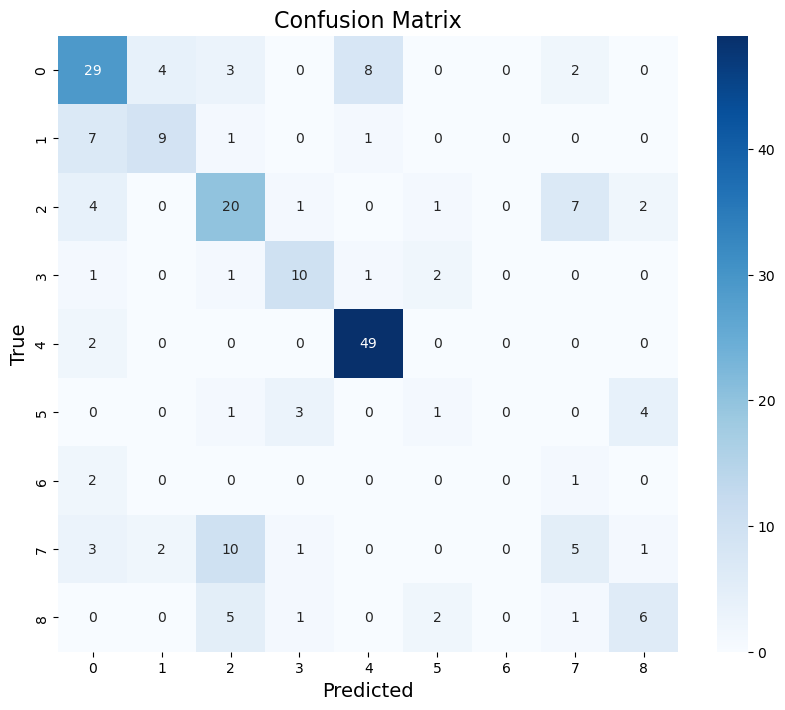

In [29]:
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=sorted(set(y)),
    yticklabels=sorted(set(y))
)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)

plt.title("Confusion Matrix", fontsize=16)
plt.show()


In [30]:
# compute accuracy of the model 
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")


Accuracy: 0.603


# Using K-fold cross val 


In [33]:
y_enc = y
n_classes = len(np.unique(y_enc))

In [34]:
import numpy as np
from collections import Counter

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from xgboost import XGBClassifier

# --- Use y_enc from step 1 ---
X_array = np.asarray(X)        # ensures slicing works for pandas
y_array = np.asarray(y_enc)
n_classes = len(np.unique(y_array))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_macro_scores = []
cm_total = np.zeros((n_classes, n_classes), dtype=int)

for fold, (train_idx, test_idx) in enumerate(skf.split(X_array, y_array), start=1):
    print(f"\n===== Fold {fold} =====")
    
    X_train, X_test = X_array[train_idx], X_array[test_idx]
    y_train, y_test = y_array[train_idx], y_array[test_idx]

    # --- Check class distribution in this fold ---
    print("Class counts train:", Counter(y_train))
    print("Class counts test :", Counter(y_test))

    # --- Choose k_neighbors safely for SMOTE ---
    classes_fold, counts_fold = np.unique(y_train, return_counts=True)
    min_count = counts_fold.min()
    k = max(1, min(min_count - 1, 5))   # must be < min_count, cap at 5
    print(f"Using k_neighbors = {k}")

    smote = SMOTE(random_state=42, k_neighbors=k)
    smt = SMOTETomek(random_state=42, smote=smote)

    # --- Resample ONLY the training set ---
    X_train_res, y_train_res = smt.fit_resample(X_train, y_train)
    print("After SMOTETomek (train):", Counter(y_train_res))

    # --- Define XGBoost model ---
    xgb = XGBClassifier(
        objective="multi:softprob",
        num_class=n_classes,
        eval_metric="mlogloss",
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",      # "gpu_hist" if you use GPU
        random_state=42,
        n_jobs=-1
    )

    # --- Train on resampled data ---
    xgb.fit(X_train_res, y_train_res)

    # --- Evaluate on original (un-resampled) test set ---
    y_pred = xgb.predict(X_test)

    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_macro_scores.append(f1_macro)
    print("Fold F1-macro:", f1_macro)

    cm = confusion_matrix(y_test, y_pred, labels=np.arange(n_classes))
    cm_total += cm

    # (Optional) per-fold report
    print(classification_report(y_test, y_pred))

print("\n===== Overall results =====")
print("F1-macro per fold:", f1_macro_scores)
print("Mean F1-macro    :", np.mean(f1_macro_scores))

print("\nAggregated confusion matrix over all folds:")
print(cm_total)



===== Fold 1 =====
Class counts train: Counter({np.int64(4): 205, np.int64(0): 186, np.int64(2): 140, np.int64(7): 88, np.int64(1): 70, np.int64(3): 60, np.int64(8): 59, np.int64(5): 34, np.int64(6): 12})
Class counts test : Counter({np.int64(4): 51, np.int64(0): 46, np.int64(2): 36, np.int64(7): 22, np.int64(1): 18, np.int64(3): 15, np.int64(8): 14, np.int64(5): 9, np.int64(6): 3})
Using k_neighbors = 5
After SMOTETomek (train): Counter({np.int64(3): 205, np.int64(4): 205, np.int64(8): 205, np.int64(1): 205, np.int64(2): 205, np.int64(7): 205, np.int64(0): 205, np.int64(5): 205, np.int64(6): 205})
Fold F1-macro: 0.44551803309317756
              precision    recall  f1-score   support

           0       0.60      0.74      0.66        46
           1       0.82      0.50      0.62        18
           2       0.56      0.75      0.64        36
           3       0.73      0.53      0.62        15
           4       0.87      0.90      0.88        51
           5       0.00      0.00

/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

Fold F1-macro: 0.47400718555485866
              precision    recall  f1-score   support

           0       0.65      0.74      0.69        46
           1       0.59      0.56      0.57        18
           2       0.60      0.83      0.70        35
           3       0.53      0.60      0.56        15
           4       0.91      0.94      0.92        52
           5       0.60      0.33      0.43         9
           6       0.00      0.00      0.00         3
           7       0.45      0.23      0.30        22
           8       0.10      0.07      0.08        14

    accuracy                           0.65       214
   macro avg       0.49      0.48      0.47       214
weighted avg       0.62      0.65      0.63       214


===== Fold 3 =====
Class counts train: Counter({np.int64(4): 205, np.int64(0): 186, np.int64(2): 141, np.int64(7): 88, np.int64(1): 70, np.int64(3): 60, np.int64(8): 58, np.int64(5): 34, np.int64(6): 12})
Class counts test : Counter({np.int64(4): 51, np.int64

/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

Fold F1-macro: 0.40757448088833326
              precision    recall  f1-score   support

           0       0.62      0.63      0.62        46
           1       0.73      0.44      0.55        18
           2       0.51      0.71      0.60        35
           3       0.39      0.47      0.42        15
           4       0.75      0.92      0.82        51
           5       0.33      0.22      0.27         9
           6       0.00      0.00      0.00         3
           7       0.18      0.09      0.12        22
           8       0.38      0.20      0.26        15

    accuracy                           0.57       214
   macro avg       0.43      0.41      0.41       214
weighted avg       0.54      0.57      0.55       214


===== Fold 4 =====
Class counts train: Counter({np.int64(4): 205, np.int64(0): 185, np.int64(2): 141, np.int64(7): 88, np.int64(1): 71, np.int64(3): 60, np.int64(8): 58, np.int64(5): 35, np.int64(6): 12})
Class counts test : Counter({np.int64(4): 51, np.int64

/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

Fold F1-macro: 0.533711686232826
              precision    recall  f1-score   support

           0       0.67      0.66      0.67        47
           1       0.59      0.76      0.67        17
           2       0.53      0.89      0.67        35
           3       0.50      0.53      0.52        15
           4       0.87      0.88      0.87        51
           5       1.00      0.38      0.55         8
           6       0.00      0.00      0.00         3
           7       0.56      0.23      0.32        22
           8       0.86      0.40      0.55        15

    accuracy                           0.67       213
   macro avg       0.62      0.53      0.53       213
weighted avg       0.68      0.67      0.65       213


===== Overall results =====
F1-macro per fold: [0.44551803309317756, 0.47400718555485866, 0.40757448088833326, 0.4388712662689271, 0.533711686232826]
Mean F1-macro    : 0.45993653040762456

Aggregated confusion matrix over all folds:
[[157  19  13   0  31   1  

/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/AI_LAB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

In [45]:
X_train_res.shape
# y_train_res.shape


(1845, 2000)

In [42]:
df_hvg_unlabeled.head()

,Coro2b,Clec9a,Tmem167b,Rag2,Adgre1,Bhlhb9,Vcam1,Mns1,Tbc1d5,Sardh,...,Mzb1,Cables1,B4galt6,Impact,Taf4b,Zfp521,Hrh4,Psma8,cluster,cell_type
c547632b57,-0.459152,-0.14691,2.564433,-0.010832,-0.265706,-0.781545,-0.604030,-0.591253,1.743835,-0.13352,...,-0.391854,-0.502104,0.023667,1.117386,-0.528065,0.186905,-0.101194,-0.054558,NaN,NaN
c2e46e7dfc,-0.459152,-0.14691,-0.767338,-0.079042,-0.265706,-0.642470,-0.604030,0.143596,1.319571,-0.13352,...,-0.391854,-0.502104,2.392045,0.808135,-0.160130,1.572204,-0.101194,-0.599173,NaN,NaN
a6f38ffd54,-0.459152,-0.14691,1.943083,-0.621492,-0.265706,-0.303591,-0.604030,-0.617422,1.786065,-0.13352,...,-0.391854,-0.502104,-0.089382,0.965157,-0.475584,-0.582101,-0.101194,-0.599173,NaN,NaN
ea7787b99f,0.696835,-0.14691,-0.767338,-0.621492,-0.265706,-0.509510,-0.604030,-1.452747,0.381054,-0.13352,...,-0.391854,0.797254,-0.875999,0.428594,-0.150019,-0.582101,-0.101194,-0.599173,NaN,NaN
c0633e93d5,-0.459152,-0.14691,1.935905,0.150703,-0.265706,0.743448,0.682123,0.655826,-0.809036,-0.13352,...,-0.391854,-0.502104,-0.875999,1.463051,2.697123,-0.582101,-0.101194,0.089505,NaN,NaN


In [43]:
X_unlabeled.head()

,Coro2b,Clec9a,Tmem167b,Rag2,Adgre1,Bhlhb9,Vcam1,Mns1,Tbc1d5,Sardh,...,Osbpl1a,Map3k8,Mzb1,Cables1,B4galt6,Impact,Taf4b,Zfp521,Hrh4,Psma8
c547632b57,-0.459152,-0.14691,2.564433,-0.010832,-0.265706,-0.781545,-0.604030,-0.591253,1.743835,-0.13352,...,1.023150,4.509292,-0.391854,-0.502104,0.023667,1.117386,-0.528065,0.186905,-0.101194,-0.054558
c2e46e7dfc,-0.459152,-0.14691,-0.767338,-0.079042,-0.265706,-0.642470,-0.604030,0.143596,1.319571,-0.13352,...,-1.174012,-0.422864,-0.391854,-0.502104,2.392045,0.808135,-0.160130,1.572204,-0.101194,-0.599173
a6f38ffd54,-0.459152,-0.14691,1.943083,-0.621492,-0.265706,-0.303591,-0.604030,-0.617422,1.786065,-0.13352,...,-0.748696,0.258587,-0.391854,-0.502104,-0.089382,0.965157,-0.475584,-0.582101,-0.101194,-0.599173
ea7787b99f,0.696835,-0.14691,-0.767338,-0.621492,-0.265706,-0.509510,-0.604030,-1.452747,0.381054,-0.13352,...,-0.853998,-0.422864,-0.391854,0.797254,-0.875999,0.428594,-0.150019,-0.582101,-0.101194,-0.599173
c0633e93d5,-0.459152,-0.14691,1.935905,0.150703,-0.265706,0.743448,0.682123,0.655826,-0.809036,-0.13352,...,-1.486778,0.352986,-0.391854,-0.502104,-0.875999,1.463051,2.697123,-0.582101,-0.101194,0.089505


In [46]:
X_unlabeled = df_hvg_unlabeled.drop(columns=['cluster', 'cell_type'])
y_pred_unlabeled = xgb.predict(X_unlabeled)


In [51]:
import pandas as pd

submission = pd.DataFrame({
    "ID": cell_ids,
    "predicted_label": y_pred_unlabeled
})

submission.head()


,ID,predicted_label
0,c547632b57,2
1,c2e46e7dfc,0
2,a6f38ffd54,0
3,ea7787b99f,2
4,c0633e93d5,0


In [52]:
submission.to_csv('/Users/pacohoche/Desktop/AI-1 Project/AI-1-Project-Single-Cell-/Data_CSV/submission_xgb_smotetomek.csv', index=False)